# Viscoelastic floating beam

## Problem description

Consider a floating shelf of thickness $H(x, t)$, with unknown viscous and elastic deflections $\eta_\nu(x, t)$ and  $\eta_e(x, t)$, and bending moments $M_e(x, t)$ and $M_\nu(x, t)$. Either bending moment at the terminus is forced by flotation conditions at that boundary. The shelf is loaded everywhere with a buoyancy force of $f = -\rho_wg\eta(x, t)$, where $\eta$ is the net deflection resulting from both viscous and elastic processes. Define $\lambda_e := \frac{E}{12(1 - \mu^2)}$, where $E$ is Young's Modulus and $\mu$ is Poisson's Ratio, and $\lambda_\nu := \frac{1}{3}\nu$, where $\nu$ is the flexural viscosity of she shelf. Then the governing equation and constitutive relation on the shelf at time $t = 0$ are:

$$
-M_e'' = -\rho_wg(\eta_\nu + \eta_e)
$$

$$
M_e = -H^3\lambda_e\eta_e''
$$ 

for an elastic system, and 

$$
-M_\nu'' = -\rho_wg(\eta_\nu + \eta_e)
$$

$$
M_\nu = -H^3\lambda_\nu\dot{\eta_\nu}''
$$ 

for a viscous system. We may solve these equations iteratively over a timestep of duration $\Delta t$. Because elastic stresses are stored, the $t$th solution for the elastic bending moment and deflection, $M_e^{(t)}$ and $\eta_e^{(t)}$, is given by

$$ -\left(M_e^{(t)} + \Sigma_{n = 0}^{t - 1}M_e^{(n)}\right)'' = -\rho_wg\left(\Sigma_{n = 0}^{t - 1}[\dot{\eta}_\nu^{(n)}\Delta t + \eta_e^{(n)}] + \eta_e^{(t)}\right)$$

$$ M_e^{(t)} + \Sigma_{n = 0}^{t - 1}M_e^{(n)} = -H^3\lambda_e\left(\eta_e^{(t)} + \Sigma_{n = 0}^{n - 1}\eta_e^{(n)}\right).$$

In contrast, because viscous stresses are not stored, the viscous stresses and bending moment at time $t$ are given by 

$$ -\left(M_\nu^{(t)}\right)'' = -\rho_wg\left(\Sigma_{n = 0}^{t - 1}[\dot{\eta}_\nu^{(n)}\Delta t + \eta_e^{(n)}] + \dot{\eta_\nu}^{(t)}\Delta t\right)$$

$$ M_\nu^{(t)} = -H^3\lambda_\nu\left(\dot{\eta}_\nu^{(t)}\right)''$$


Let $n$ and $m$ be arbitrary functions in $x$. From the product rule and the Fundamental Theorem of Calculus, it can be derived that the corresponding weak forms for the elastic equations at time $t$ are:

$$
\int_xm'\left(M_e^{(t)} + \Sigma_{n = 0}^{t - 1}M_e^{(n)} \right)' - \left[m\left(M_e^{(t)} + \Sigma_{n = 0}^{t - 1}M_e^{(n)}\right)'\right]_{x_0}^{x_1} = -\int_xm\rho_wg\left(\Sigma_{n = 0}^{t - 1}\left[\dot{\eta}^{(n)}_\nu\Delta t + \eta_e^{(n)}\right] + \eta_e^{(t)}\right)
$$

$$
\int_xn\left(M_e^{(t)} + \Sigma_{n = 0}^{t - 1}M_e^{(n)}\right) = \int_x(H^3\lambda_e n)'\left(\eta_e^{(t)} + \Sigma_{n = 0}^{n - 1}\eta_e^{(n)}\right)' - \left[H^3\lambda_e n\left(\eta_e^{(t)} + \Sigma_{n = 0}^{n - 1}\eta_e^{(n)}\right)'\right]_{x_0}^{x_1}
$$

while the analogous forms for the viscous equations are:

$$
\int_xm'\left(M_\nu^{(t)}\right)' - \left[m\left(M_\nu^{(t)}\right)'\right]_{x_0}^{x_1} = -\int_xm\rho_wg\left(\Sigma_{n = 0}^{t - 1}\left[\dot{\eta}^{(n)}_\nu\Delta t + \eta_e^{(n)}\right] + \dot{\eta}_{\nu}^{(t)}\Delta t\right)
$$

$$
\int_xnM_\nu^{(t)} = \int_x(H^3\lambda_\nu n)'\left(\dot{\eta}_\nu^{(t)}\right)' - \left[H^3\lambda_\nu n\left(\dot{\eta}_\nu^{(t)}\right)'\right]_{x_0}^{x_1}
$$


## Boundary conditions

We need eight boundary conditions to solve this problem:

- On the left boundary, assume that $\dot{\eta}_{\nu,0} = \eta_{e, 0} = M_{\nu, 0} = M_{e, 0} = 0$ (i.e., the grounding line acts as a hinge, permitting neither deflection nor bending). These four boundary conditions can be enforced directly via firedrake's ```DirichletBC```.

- On the right boundary, $M'_{\nu, 1} = M'_{e, 1} = 0$ (no shear force acts on the terminal cliff). This can be enforced using the penalty method.

- On the right boundary, $M_{\nu, 1} = M_{e, 1} = -\frac{1}{12}\rho_igH^3(2\varrho^2 - 3\varrho + 1)$, where $\varrho$ is the proportion of ice thickness below the waterline (this proportion is generally not equal to $\frac{\rho_i}{\rho_w}$, as the terminus of the shelf will deflect downward from its equilibrium position). This final boundary condition is enforced by adding the boundary term

$$
\int_\Gamma m\left(M_e^{(t)} + \Sigma_{n = 0}^{t - 1}M_e^{(n)} \right) = -\int_\Gamma\frac{1}{12}\rho_igH^3(2\varrho^2 - 3\varrho + 1)m
$$

for the elastic part and 

$$\int_\Gamma mM_\nu^{(t)} = -\int_\Gamma\frac{1}{12}\rho_igH^3(2\varrho^2 - 3\varrho + 1)m$$

for the viscous part. 

## Imports

In [1]:
from firedrake import *
import matplotlib.pyplot as plt
import numpy as np
import tqdm
flexure_type = 'viscous' #can be viscoelastic, viscous, or elastic

## Material parameters

In [2]:
year = 60*60*24*365.25 #seconds in a year
H_gl = 500 #shelf thickness in meters
H = H_gl
ρ_i = 917 #density of ice (kg/m^3)
ρ_w = 1024 #density of seawater
ϱ = ρ_i/ρ_w #density ratio
s = (1 - ϱ)*H
b = -ϱ*H
g = 9.81 #gravitational constant (N/kg)

Δt = 1
num_timesteps = int(100/Δt) + 1 #spin up for two years


E = 1e9 #Young's Modulus (Pa)
μ = 1/3 #Poisson's Ratio
ν = 5e15/year #viscosity (Pa yr)
λ_e = E/(12*(1 - μ**2)) #1D equivalent of Lame parameter
λ_ν = 1/3*ν
α = 1e10 #large number for penalty method

## Meshing 

In [3]:
nx = 1000 #number of nodes
D_e = sqrt(sqrt((3*ρ_w*g*(1 - μ**2)/(E*H**3)))) #for determining the length scale; see above
D_ν = sqrt(sqrt((3*ρ_w*g*Δt)/(4*ν*H**3)))
n_length = 1 #see above
Lx = 2*n_length*pi/D_e if flexure_type == 'elastic' else 2*n_length*pi/D_ν#length of mesh in meters
Lx = max(2*n_length*pi/D_e, 2*n_length*pi/D_ν) if flexure_type == 'viscoelastic' else Lx
Lx = 10000
print(f'L = {Lx:.2f} meters')
mesh = IntervalMesh(nx, Lx)

Q1 = FunctionSpace(mesh, 'CG', 3) #this will be η's function space
Q2 = FunctionSpace(mesh, 'CG', 3) #and M's function space
Q = Q1*Q2 #mixed function space for (η, M)

η, M = TrialFunctions(Q) #trial functions for the elastic deflection η, and moment M_xx
n, m = TestFunctions(Q)
q = Function(Q) #q = (η solution, M solution)

η_ν, M_ν = TrialFunctions(Q) #trial functions for the elastic deflection η, and moment M_xx
n_ν, m_ν = TestFunctions(Q)
q_ν = Function(Q) #q = (η solution, M solution)

Ση_e = Function(Q1).project(Constant(0))
Ση_νΔt = Function(Q1).project(Constant(0))
Ση = Function(Q1).project(Ση_e + Ση_νΔt)

ΣM_e = Function(Q2).project(Constant(0))
ΣM_ν = Function(Q2).project(Constant(0))
ΣM = Function(Q2).project(ΣM_e + ΣM_ν)

x = SpatialCoordinate(mesh)
X = np.arange(0, Lx, 1) #for plotting later

s = Function(Q1).project(Constant(s))
H = Function(Q1).project(Constant(H))
σ = Function(Q1).project(Constant(0))

L = 10000.00 meters


## Spin up geometry to steady state

Obtain initial (pre-flexure) steady state by iteratively solving for velocity $u$ and thickness $H$, where $u$ satisfies 

$$u' = A\tau_{xx}^3,$$

where $\tau_{xx} = \frac{1}{4}\rho_ig(1 - \varrho)H$ is the analytic solution for the deviatoric stress field in 1D; and at timestep $t$, $H$ satisfies 

$$\frac{\partial}{\partial t}H^{(t)} + (uH^{(t)})' \approx \frac{H^{(t)} - H^{(t - 1)}}{\Delta t} + (uH^{(t)})' = 0.$$

100%|███████████████████████████████████████| 1000/1000 [00:24<00:00, 41.37it/s]


terminus velocity =  28.490472326658768


<Figure size 640x480 with 0 Axes>

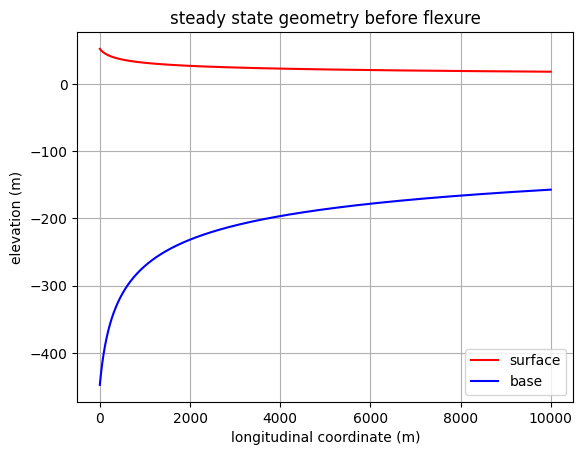

In [4]:
u = TrialFunction(Q1)
v = TestFunction(Q1)
ϕu = Function(Q1)

h = TrialFunction(Q1)
w = TestFunction(Q1)
ϕh = Function(Q1)
A = 10
dt = 2

u_gl = 10 #meters per year
flow_n = 3
ν = 1e6*1/A if flow_n == 1 else ν 
λ_ν = 1/3*ν

plt.figure()
for step in tqdm.trange(int(2*(Lx/u_gl)/dt)): #spin up for two residence times
    
    τ_flow = Function(Q1).project(1/4*ρ_i*g*(1 - ρ_i/ρ_w)*H/1e6)
    
    a = grad(u)[0]*v*dx 
    L = v*A*τ_flow**flow_n*dx
    
    BC_u = DirichletBC(Q1, u_gl, 1) #10 m/yr at upstream boundary
    
    solve(a == L, ϕu, bcs = [BC_u])
    
    u_ = Function(Q1).project(ϕu)

    a = w*h*dx + w*u_*grad(h)[0]*dt*dx + w*h*grad(u_)[0]*dt*dx
    L = w*H*dx 
    BC_h = DirichletBC(Q1, H_gl, 1) #H_gl meters at upstream boundary
    solve(a == L, ϕh, bcs = [BC_h])
    H = Function(Q1).project(ϕh)

s = Function(Q1).project((1 - ϱ)*H)
b = Function(Q1).project(s - H) 
print('terminus velocity = ', u_.at(Lx, tolerance = 1e-10))

s0 = s.copy(deepcopy = True)
b0 = b.copy(deepcopy = True)
H0 = H.copy(deepcopy = True)

# b = Function(Q1).project(conditional(x[0] > Lx - 2000, b*(1 - (x[0] - (Lx - 2000))/(Lx - (Lx - 2000))), b))
# H = Function(Q1).project(s - b)
offset = int(H.at(Lx, tolerance = 1e-10)*0.99)

plt.figure()
plt.title('steady state geometry before flexure')
plt.plot(s.at(X, tolerance = 1e-10), color = 'red', label = 'surface')
plt.plot(b.at(X, tolerance = 1e-10), color = 'blue', label = 'base')
plt.legend()
plt.ylabel('elevation (m)')
plt.xlabel('longitudinal coordinate (m)')
plt.grid()
plt.show()

## Solve with firedrake

From the weak forms derived above, define

$$ 
a_e\left((\eta_e^{(t)}, M_e^{(t)}), (n, m)\right) := \int_xm'\left(M_e^{(t)}\right)' + \int_xm\rho_wg\eta_e^{(t)} + \int_xnM_e^{(t)} - \int_x(H^3\lambda_en)'\left(\eta_e^{(t)}\right)' + \int_\Gamma mM_e^{(t)}
$$

$$
L_e(n, m) := -\int_xm'\left(\Sigma_{n = 0}^{t - 1}M_e^{(n)}\right)' - \int_xm\rho_wg\left(\Sigma_{n = 0}^{t - 1}\left[\dot{\eta}_\nu^{(n)}\Delta t + \eta_e^{(n)}\right]\right) - \int_xn\Sigma_{n = 0}^{t - 1}M_e^{(n)} + \int_x\left(H^3\lambda_en\right)'\left(\Sigma_{n = 0}^{t - 1}\eta_e^{(n)}\right)' + 
$$

$$
-\int_\Gamma m\Sigma_{n = 0}^{t - 1}M_e^{(n)} - \int_\Gamma\frac{1}{12}\rho_igH^3(2\varrho^2 - 3\varrho + 1)m
$$

for the elastic part and 


$$a_\nu\left((\dot{\eta}_\nu^{(t)}, M_\nu^{(t)}), (n, m)\right) = \int_xm'\left(M_\nu^{(t)}\right) + \int_xm\rho_wg\dot{\eta}_\nu^{(t)}\Delta t + \int_xnM_\nu^{(t)} - \int_x(H^3\lambda_\nu n)'\left(\dot{\eta}_\nu^{(t)}\right)' + \int_\Gamma mM_\nu^{(t)}$$
$$L_\nu(n, m) = -\int_xm\rho_wg\left(\Sigma_{n = 0}^{t - 1}\left[\dot{\eta}_\nu^{(n)} + \eta_e^{(n)}\right]\right) - \int_\Gamma\frac{1}{12}\rho_igH^3(2\varrho^2 - 3\varrho + 1)m$$

for the viscous part. For each time step, the goal is now to find $\left(\eta_e^{(t)}, M_e^{(t)}\right)$ and $\left(\dot{\eta}_\nu^{(t)}, M_\nu^{(t)}\right)$ such that $a_e = L_e$ and $a_\nu = L_\nu$ for all $(m, n)$. 

100%|█████████████████████████████████████████| 101/101 [01:31<00:00,  1.10it/s]


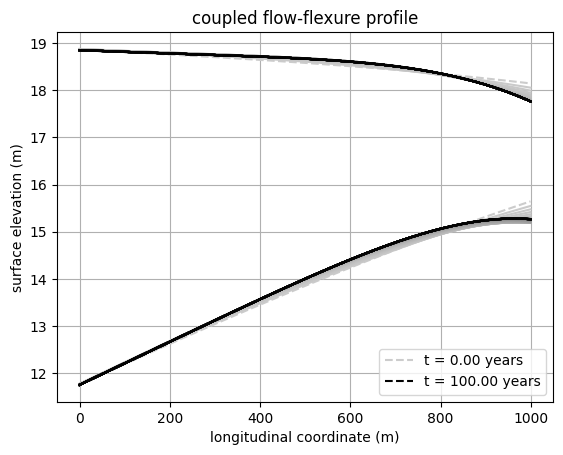

In [5]:
plt.figure()
plt.title('coupled flow-flexure profile')

for step in tqdm.trange(num_timesteps):

    τ_flow = Function(Q1).project((1/4*ρ_i*g*H - 1/(4*H)*ρ_w*g*b**2)/1e6)
    
    a = grad(u)[0]*v*dx 
    L = v*A*τ_flow**flow_n*dx
    
    BC_u = DirichletBC(Q1, u_gl, 1) #u_gl m/yr at upstream boundary
    
    solve(a == L, ϕu, bcs = [BC_u])
    
    u_ = Function(Q1).project(ϕu)

    a = w*h*dx + w*grad(u_*h)[0]*Δt*dx
    L = w*H*dx 
    BC_h = DirichletBC(Q1, H_gl, 1) #H_gl meters at upstream boundary
    solve(a == L, ϕh, bcs = [BC_h])
    ΔH = Function(Q1).project(ϕh - H)
    H = Function(Q1).project(ϕh)

    a = w*h*dx + w*grad(u_*h)[0]*Δt*dx
    L = w*s*dx # + w*η_ν_temp*Δt*dx
    BC_h = DirichletBC(Q1, (1 - ρ_i/ρ_w)*H_gl, 1) #H_gl meters at upstream boundary
    solve(a == L, ϕh, bcs = [BC_h])
    Δs = Function(Q1).project(ϕh - s)
    s = Function(Q1).project(ϕh)

    b = Function(Q1).project(s - H)

    σ = Function(Q1).project(-b**2/(2*H)*ρ_w*g)

    if flexure_type in ['viscous', 'viscoelastic']:

        h_ab = Function(Q1).project(s - (1 - ρ_i/ρ_w)*H)
        ϱ = Function(Q1).project(1 - s/H)
    
        a_ν = grad(m_ν)[0]*grad(M_ν)[0]*dx + ρ_w*g*η_ν*Δt*m_ν*dx + n_ν*M_ν*dx - grad(H**3*λ_ν*n_ν)[0]*grad(η_ν)[0]*dx + M_ν*m_ν*ds
        a_ν += m*grad(σ)[0]*grad(η)[0]*dx #add the flow stress term
        L_ν = -ρ_w*g*h_ab*m_ν*dx - 1/12*ρ_i*g*H**3*(2*ϱ**2 - 3*ϱ + 1)*m_ν*ds#  - 1/2*ρ_i*g*H**2*Ση*(ϱ - 1)*m*ds
        L_ν += m*grad(σ)[0]*grad(Ση)[0]*dx
        
        bc_η = DirichletBC(Q.sub(0), 0, 1) #η = 0 on left boundary
        bc_M = DirichletBC(Q.sub(1), 0, 1) #M = 0 on left boundary
        a_ν += 1/2*α**2*n_ν*grad(M_ν)[0]*ds #also enforce M' = 0 at terminus
        
        solve(a_ν == L_ν, q_ν, bcs = [bc_η, bc_M])
        
        Ση_νΔt = Function(Q1).project(Ση_νΔt + q_ν[0]*Δt) #total viscous deflection to date
        ΣM_ν = Function(Q2).project(q_ν[1]) #the viscous stresses have no memory!
        Ση = Function(Q1).project(Ση_νΔt + Ση_e) #net deflection
        ΣM = Function(Q2).project(ΣM_ν + ΣM_e) #net bending moment
        
        s = Function(Q1).project(s + q_ν[0]*Δt)
        b = Function(Q1).project(b + q_ν[0]*Δt)

    if flexure_type in ['elastic', 'viscoelastic']:
        
        h_ab = Function(Q1).project(s - (1 - ρ_i/ρ_w)*H)
        ϱ = Function(Q1).project(1 - s/H)


        a_e = grad(m)[0]*grad(M)[0]*dx +  ρ_w*g*η*m*dx + n*M*dx - grad(H**3*λ_e*n)[0]*grad(η)[0]*dx + M*m*ds
        a_e += m*grad(σ)[0]*grad(η)[0]*dx #add the flow stress term
        L_e = -grad(m)[0]*grad(ΣM_e)[0]*dx - ρ_w*g*h_ab*m*dx - n*ΣM_e*dx + grad(H**3*λ_e*n)[0]*grad(Ση_e)[0]*dx
        L_e += -m*ΣM_e*ds - 1/12*ρ_i*g*H**3*(2*ϱ**2 - 3*ϱ + 1)*m*ds # - 1/2*ρ_i*g*H**2*Ση*(ϱ - 1)*m*ds
        L_e += -m*grad(σ)[0]*grad(Ση)[0]*dx
        
        bc_η = DirichletBC(Q.sub(0), 0, 1) #η = 0 on left boundary
        bc_M = DirichletBC(Q.sub(1), 0, 1) #M = 0 on left boundary
        a_e += 1/2*α**2*n*grad(M)[0]*ds #also enforce M' = 0 at terminus
        
        solve(a_e == L_e, q, bcs = [bc_η, bc_M])
        
        Ση_e = Function(Q1).project(Ση_e + q[0])
        ΣM_e = Function(Q2).project(ΣM_e + q[1])
        Ση = Function(Q1).project(Ση_e + Ση_νΔt)
        ΣM = Function(Q2).project(ΣM_e + ΣM_ν)
        
        s = Function(Q1).project(s + q[0])
        b = Function(Q1).project(b + q[0])

    σ_flexure_surf = Function(Q2).project(12/H**3*ΣM*H/2)
    σ_flexure_base = Function(Q2).project(12/H**3*ΣM*-H/2)
    
    
    color = 0.8*(1 - step/num_timesteps)
    start = -1000
    if step in [0, num_timesteps - 1]:
        plt.plot(s.at(X, tolerance = 1e-10)[start:], color = str(color), linestyle = 'dashed',
                 label = f't = {step*Δt:.2f} years')
        plt.plot(Function(Q1).project(b + offset).at(X, tolerance = 1e-10)[start:], 
                 linestyle = 'dashed', color = str(color))
    else:
        plt.plot(s.at(X, tolerance = 1e-10)[start:], color = str(color))
        plt.plot(Function(Q1).project(b + offset).at(X, tolerance = 1e-10)[start:], color = str(color))
        

# plt.ylim(25, 34)
plt.grid()
plt.legend()#facecolor = '0.9')
plt.xlabel('longitudinal coordinate (m)')
plt.ylabel('surface elevation (m)')
plt.show()

## Compare with a baseline solution

Finally, compare with the shelf profile which would emerge in the absence of flow coupling:

100%|█████████████████████████████████████████| 101/101 [01:39<00:00,  1.01it/s]


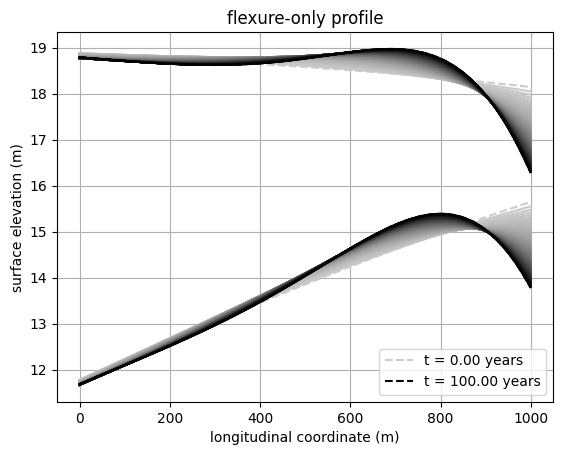

In [6]:
s = s0.copy(deepcopy = True) #reset to initial steady state geometry
b = b0.copy(deepcopy = True)
H = H0.copy(deepcopy = True) 

plt.figure()
plt.title('flexure-only profile')

for step in tqdm.trange(num_timesteps):

    if flexure_type in ['viscous', 'viscoelastic']:

        h_ab = Function(Q1).project(s - (1 - ρ_i/ρ_w)*H)
        ϱ = Function(Q1).project(1 - s/H)
    
        a_ν = grad(m_ν)[0]*grad(M_ν)[0]*dx + ρ_w*g*η_ν*Δt*m_ν*dx + n_ν*M_ν*dx - grad(H**3*λ_ν*n_ν)[0]*grad(η_ν)[0]*dx + M_ν*m_ν*ds
        L_ν = -ρ_w*g*h_ab*m_ν*dx - 1/12*ρ_i*g*H**3*(2*ϱ**2 - 3*ϱ + 1)*m_ν*ds#  - 1/2*ρ_i*g*H**2*Ση*(ϱ - 1)*m*ds
        
        bc_η = DirichletBC(Q.sub(0), 0, 1) #η = 0 on left boundary
        bc_M = DirichletBC(Q.sub(1), 0, 1) #M = 0 on left boundary
        a_ν += 1/2*α**2*n_ν*grad(M_ν)[0]*ds #also enforce M' = 0 at terminus
        
        solve(a_ν == L_ν, q_ν, bcs = [bc_η, bc_M])
        
        Ση_νΔt = Function(Q1).project(Ση_νΔt + q_ν[0]*Δt) #total viscous deflection to date
        ΣM_ν = Function(Q2).project(q_ν[1]) #the viscous stresses have no memory!
        Ση = Function(Q1).project(Ση_νΔt + Ση_e) #net deflection
        ΣM = Function(Q2).project(ΣM_ν + ΣM_e) #net bending moment
        
        s = Function(Q1).project(s + q_ν[0]*Δt)
        b = Function(Q1).project(b + q_ν[0]*Δt)

    if flexure_type in ['elastic', 'viscoelastic']:
        
        h_ab = Function(Q1).project(s - (1 - ρ_i/ρ_w)*H)
        ϱ = Function(Q1).project(1 - s/H)


        a_e = grad(m)[0]*grad(M)[0]*dx +  ρ_w*g*η*m*dx + n*M*dx - grad(H**3*λ_e*n)[0]*grad(η)[0]*dx + M*m*ds
        L_e = -grad(m)[0]*grad(ΣM_e)[0]*dx - ρ_w*g*h_ab*m*dx - n*ΣM_e*dx + grad(H**3*λ_e*n)[0]*grad(Ση_e)[0]*dx
        L_e += -m*ΣM_e*ds - 1/12*ρ_i*g*H**3*(2*ϱ**2 - 3*ϱ + 1)*m*ds # - 1/2*ρ_i*g*H**2*Ση*(ϱ - 1)*m*ds
        
        bc_η = DirichletBC(Q.sub(0), 0, 1) #η = 0 on left boundary
        bc_M = DirichletBC(Q.sub(1), 0, 1) #M = 0 on left boundary
        a_e += 1/2*α**2*n*grad(M)[0]*ds #also enforce M' = 0 at terminus
        
        solve(a_e == L_e, q, bcs = [bc_η, bc_M])
        
        Ση_e = Function(Q1).project(Ση_e + q[0])
        ΣM_e = Function(Q2).project(ΣM_e + q[1])
        Ση = Function(Q1).project(Ση_e + Ση_νΔt)
        ΣM = Function(Q2).project(ΣM_e + ΣM_ν)
        
        s = Function(Q1).project(s + q[0])
        b = Function(Q1).project(b + q[0])

    σ_flexure_surf = Function(Q2).project(12/H**3*ΣM*H/2)
    σ_flexure_base = Function(Q2).project(12/H**3*ΣM*-H/2)
    
    
    color = 0.8*(1 - step/num_timesteps)
    start = -1000
    if step in [0, num_timesteps - 1]:
        plt.plot(s.at(X, tolerance = 1e-10)[start:], color = str(color), linestyle = 'dashed',
                 label = f't = {step*Δt:.2f} years')
        plt.plot(Function(Q1).project(b + offset).at(X, tolerance = 1e-10)[start:], 
                 linestyle = 'dashed', color = str(color))
    else:
        plt.plot(s.at(X, tolerance = 1e-10)[start:], color = str(color))
        plt.plot(Function(Q1).project(b + offset).at(X, tolerance = 1e-10)[start:], color = str(color))
        

# plt.ylim(25, 34)
plt.grid()
plt.legend()#facecolor = '0.9')
plt.xlabel('longitudinal coordinate (m)')
plt.ylabel('surface elevation (m)')
plt.show()